In [2]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import stat
import time

In [4]:
pickle_path = '/content/drive/Shareddrives/cs145project/pickles'

names = {
      'sgd': 'sgd_model.pickle',
      'spacy': 'spacy_model.pickle',
      'bert': 'bert_model.pickle',
      'neural': 'nn_model.pickle',
      'data_train': 'data_train.pickle',
      'heads':'SGD_Classified_Headlines.pkl',
      'major':'majority_vote_sentiment.pkl',
  }


In [5]:
pickle_path2 = '/content/drive/Shareddrives/cs145project/filtered_data'
def unpickle_obj(name,path):
  try:
    load_path = os.path.join(path, names[name])
  except KeyError as ke:
    raise KeyError(f"'{name}' is not a supported object name. Supported objects are:\n"
                   f"{names.keys()}")
  try:
    with open(load_path, 'rb') as fd:
      return pickle.load(fd)
  except FileNotFoundError as err:
    raise FileNotFoundError(f"No pickled file for '{name}' found.\n"
                            f"{err}")

In [6]:
train_data = unpickle_obj('data_train',pickle_path)
print('train_data loaded from pickled object')
headlines=unpickle_obj('major',pickle_path2)
print('heads loaded from pickled object')

train_data loaded from pickled object
heads loaded from pickled object


# Headline Correlation And Statistical Analysis

In [7]:
def agg():
  # Return dictionary {count:moves}, where count is a possible count of the last 5 headline sentiments, and moves is a vector of all
  # % moves the day after a count occurs

  # Step 1, for each stock and day, find count
  count_to_move=dict()
  for sym, sym_df in train_data.items():
    # Filter headline df to just the company
    ticker=sym.upper()
    working_df=headlines.loc[headlines['stock']==ticker]
    
    # Sort by date 
    working_df.sort_values('date',inplace=True,ascending=False)
    inp_df=sym_df['input']

    for i in range(0,inp_df.shape[0]-1):
      # Only working with the days where there are headlines before them
      if (inp_df.iloc[i]['Date']>working_df.iloc[-1]['date']):
        # Filter the df so it's only headlines on the company before the move
        filtered_df=working_df.loc[working_df['date']<inp_df.iloc[i]['Date']]
        # Get 5 latest classified headlines:
        latest=filtered_df.head(5 )
        count=[0,0,0]
        for j in range(latest.shape[0]):
          if latest.iloc[j]['sentiment']=='positive':
            count[0]+=1
          elif latest.iloc[j]['sentiment']=='neutral':
            count[1]+=1
          elif latest.iloc[j]['sentiment']=='negative':
            count[2]+=1
        # Calculate movement from current day's stock to next day's
        movement=((inp_df.iloc[i+1]['Close']-inp_df.iloc[i]['Close'])/(inp_df.iloc[i]['Close']))*100
        key=str(count)
        if pd.isna(movement)==False:
          try:
            count_to_move[key].append(movement)
          except:
            seq=[movement]
            count_to_move[key]=seq
  return count_to_move

In [8]:
def get_stats():
  dict_of_moves=agg()
  count_to_stats=dict()
  for count,seq in dict_of_moves.items():
    var=np.var(seq)
    avg=np.mean(seq)
    count_to_stats[count]=[avg,var]
  return count_to_stats,dict_of_moves

In [9]:
statistics,movements=get_stats()
print(statistics)

<ipython-input-7-9b8a107b1d19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values('date',inplace=True,ascending=False)


{'[0, 1, 0]': [0.09713525890687358, 4.620701939535634], '[0, 2, 0]': [0.1133147878613512, 4.435510127301241], '[1, 2, 0]': [-0.05359536093750865, 1.5684015617097813], '[2, 2, 0]': [0.042918695245893715, 1.7522487280493042], '[2, 3, 0]': [0.062007755873084706, 3.806106715480112], '[3, 2, 0]': [0.06086986333452381, 3.2784623195372364], '[1, 4, 0]': [0.048094934496978055, 4.06365068868791], '[0, 5, 0]': [0.028105558185123444, 4.5486708061877055], '[0, 4, 1]': [0.0009121305116079386, 6.812922245477024], '[0, 3, 2]': [-0.06895580300946602, 6.731615586687238], '[1, 3, 1]': [0.046255399042306335, 5.233457655859121], '[0, 2, 3]': [-0.13711093784861797, 14.258925938316485], '[1, 1, 3]': [-0.08125958324762572, 11.138883327746566], '[2, 1, 2]': [-0.08749876103248404, 5.188900203775814], '[4, 1, 0]': [0.09349531638396603, 3.172314361787412], '[2, 2, 1]': [0.04988095303116975, 5.725124356077674], '[3, 1, 1]': [0.1603616636442013, 4.52720357149932], '[1, 2, 2]': [-0.0022986694122541485, 6.9085559026

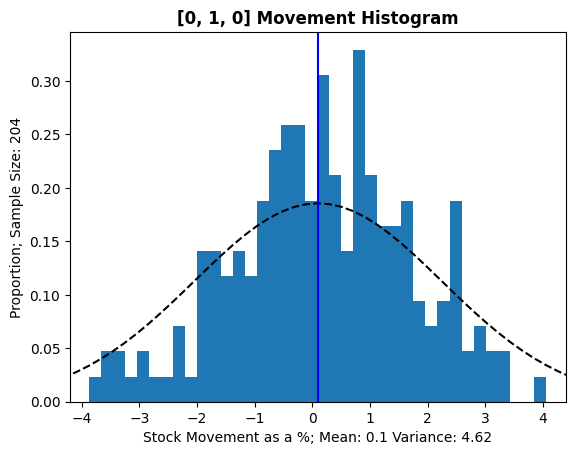

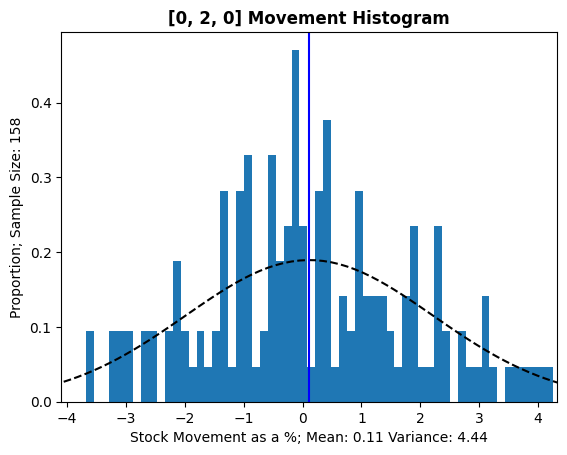

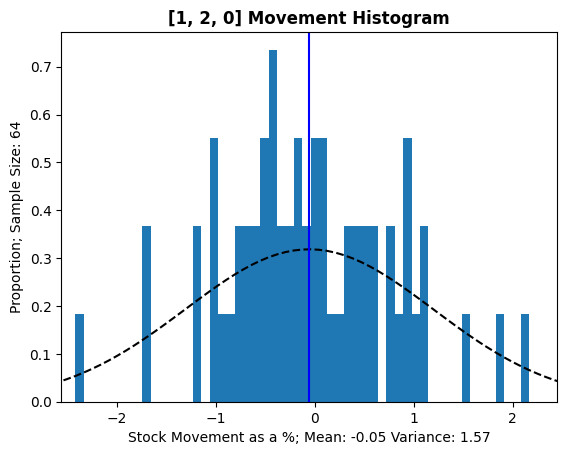

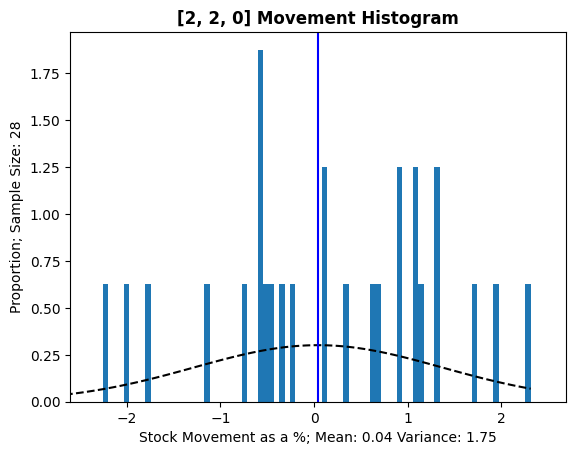

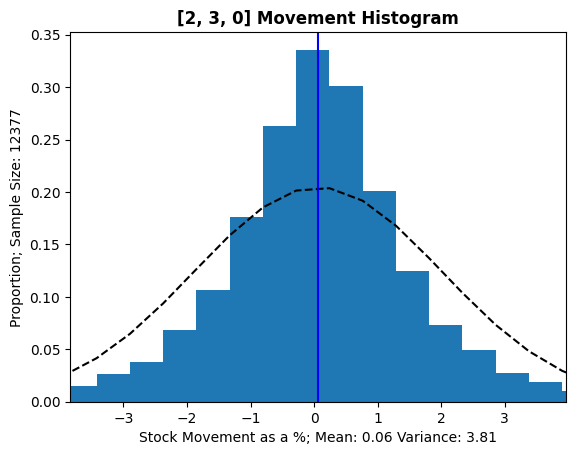

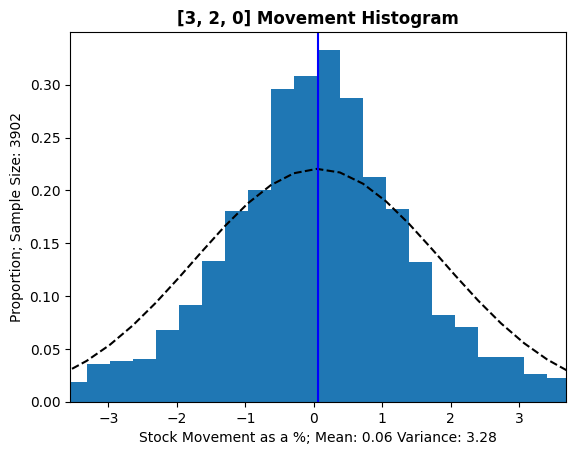

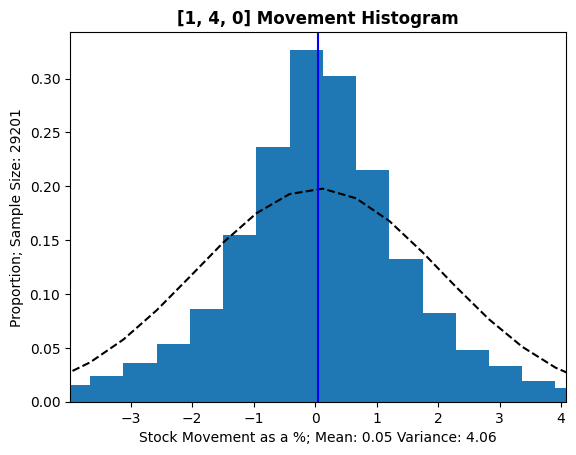

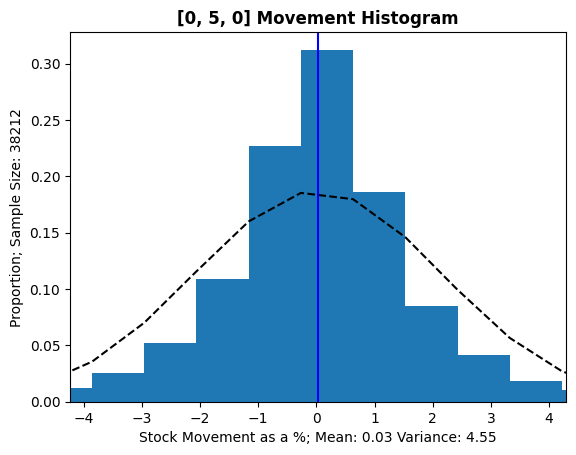

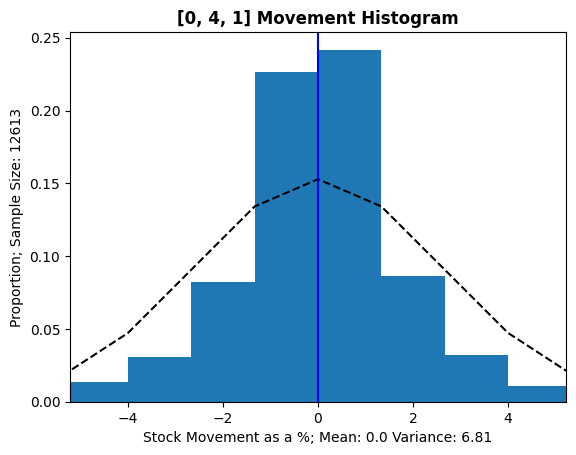

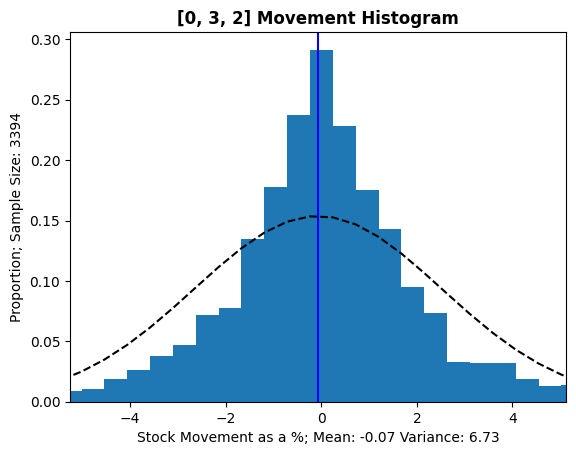

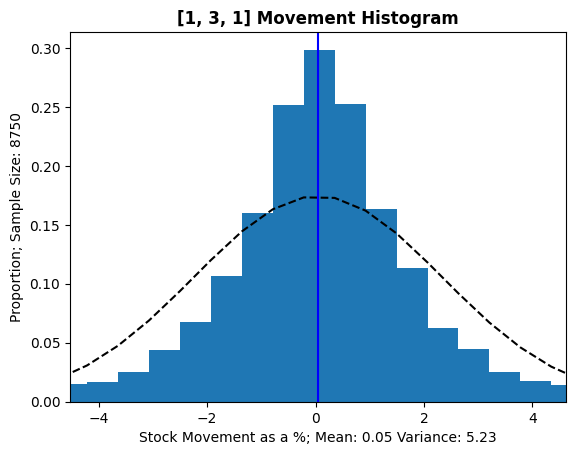

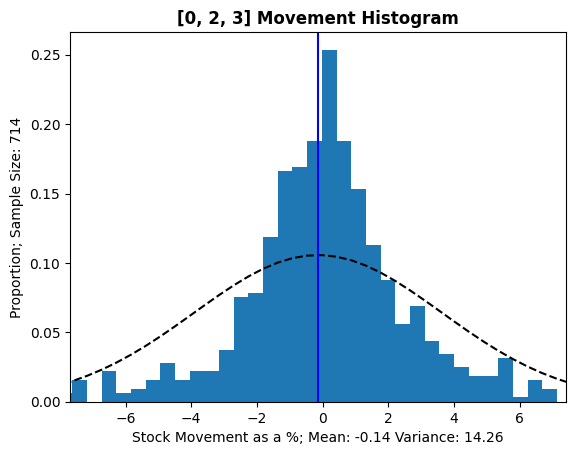

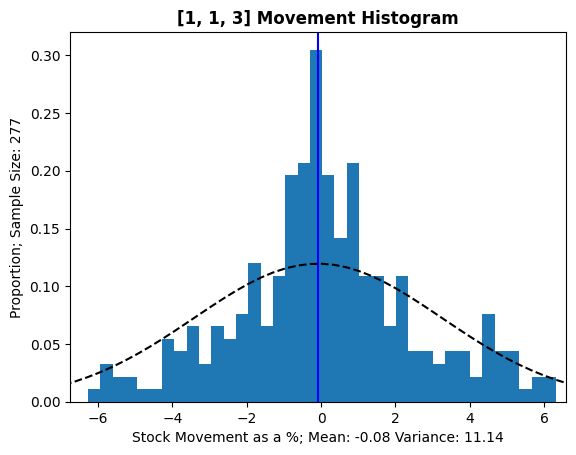

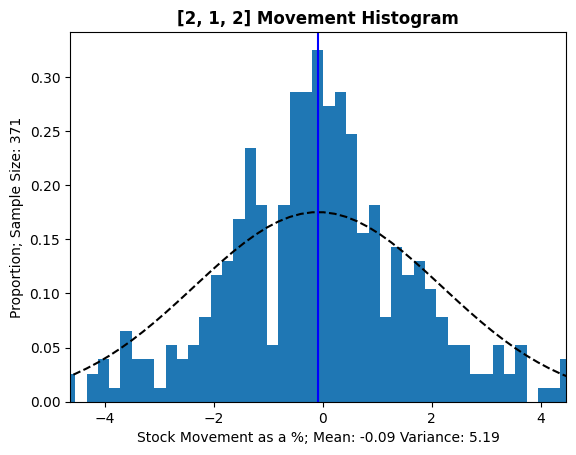

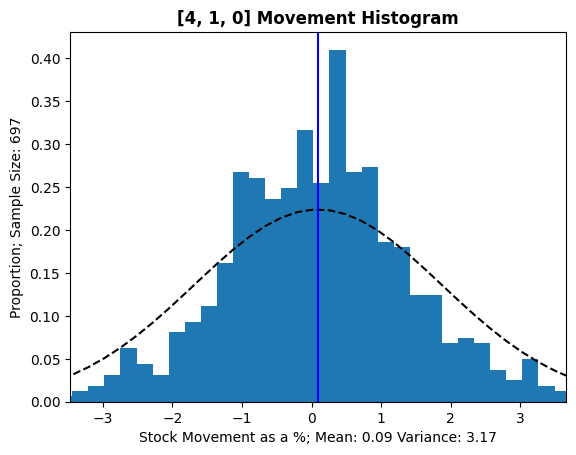

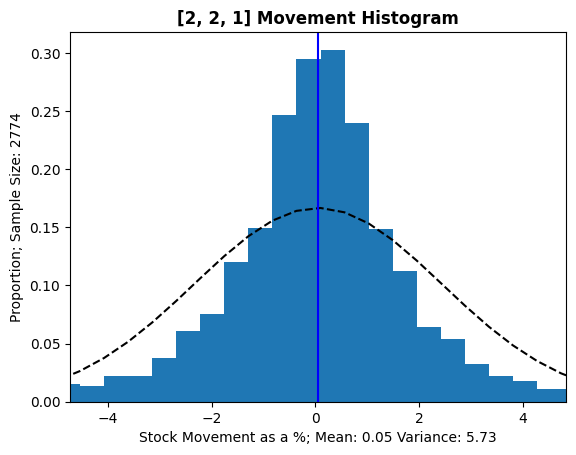

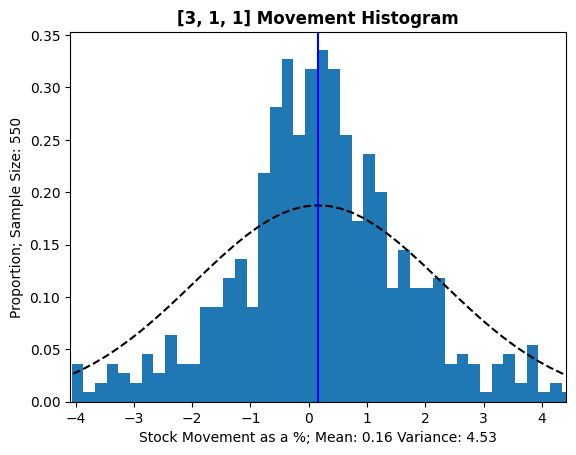

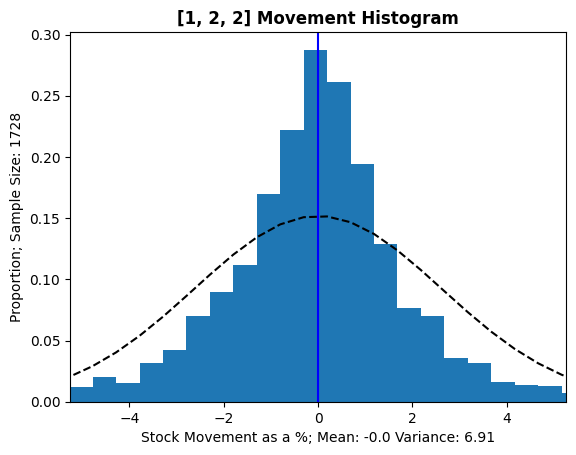

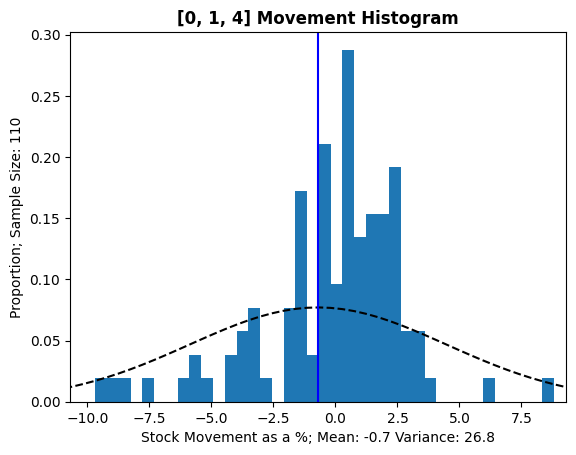

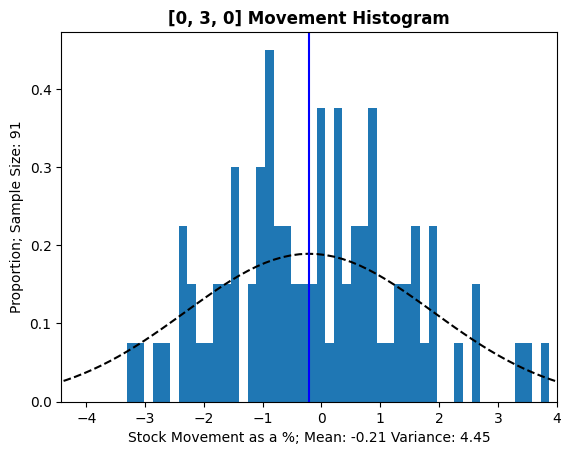

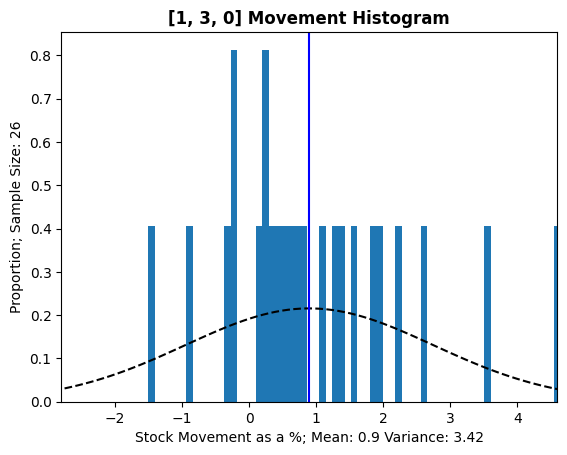

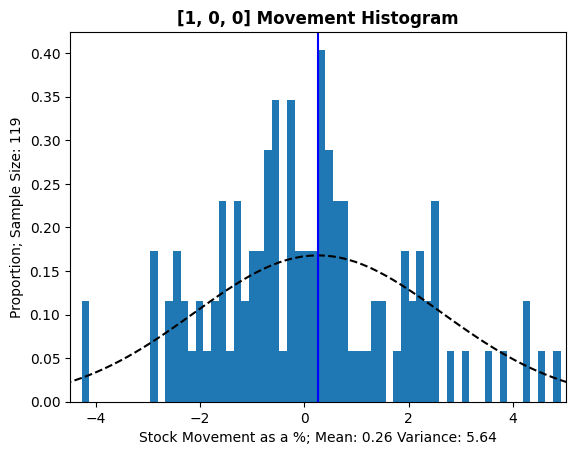

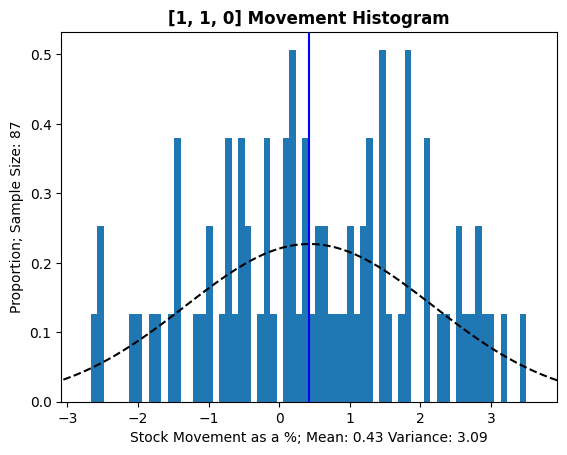

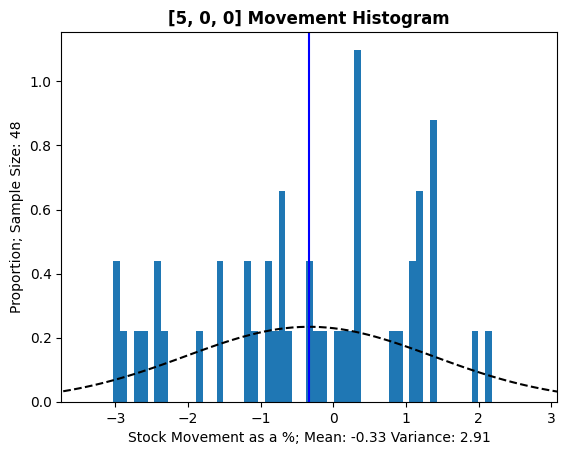

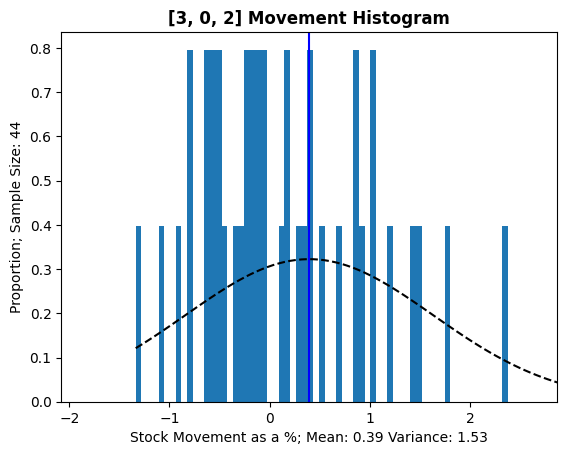

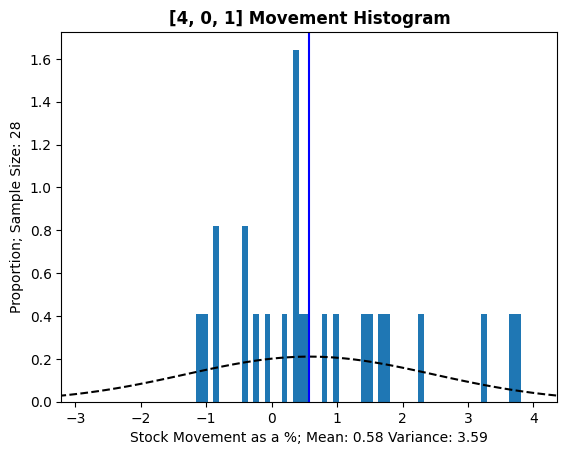

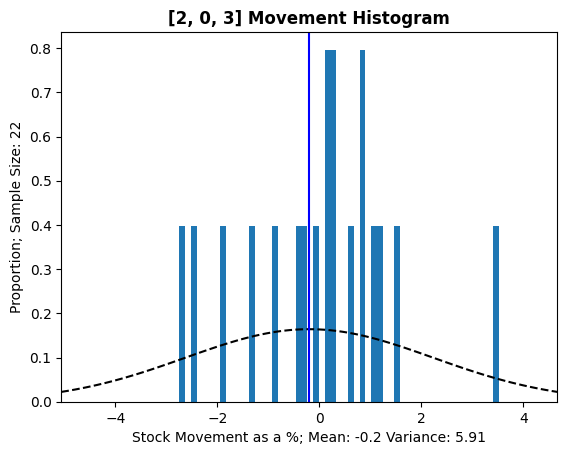

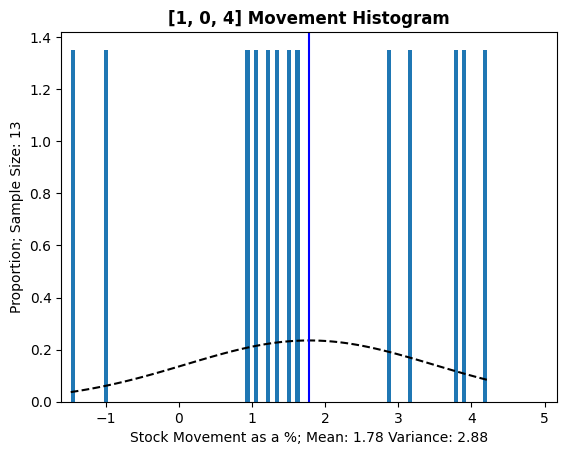

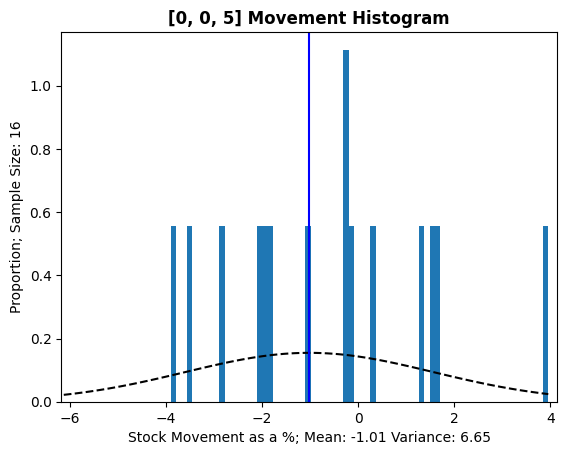

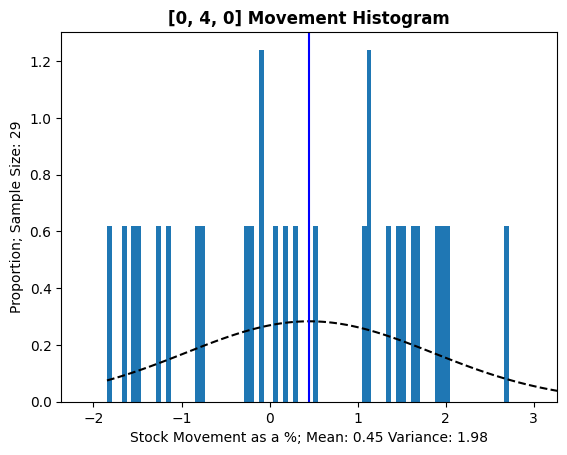

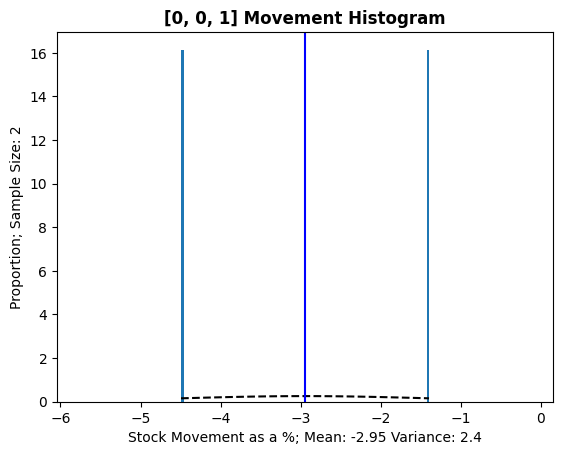

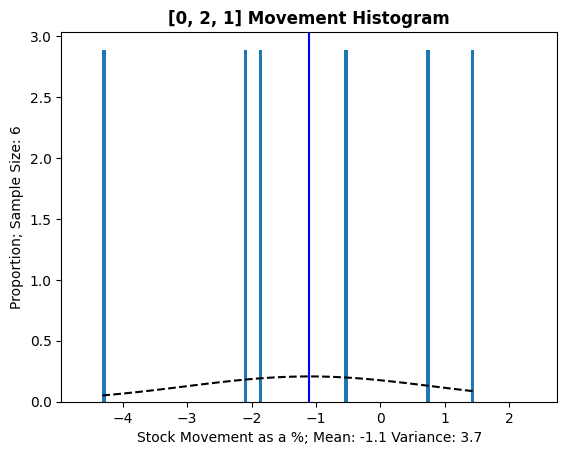

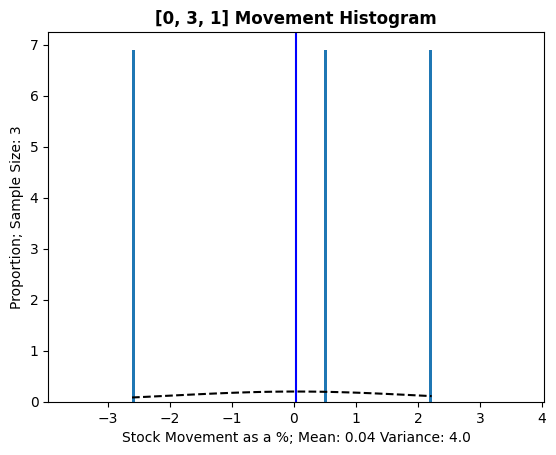

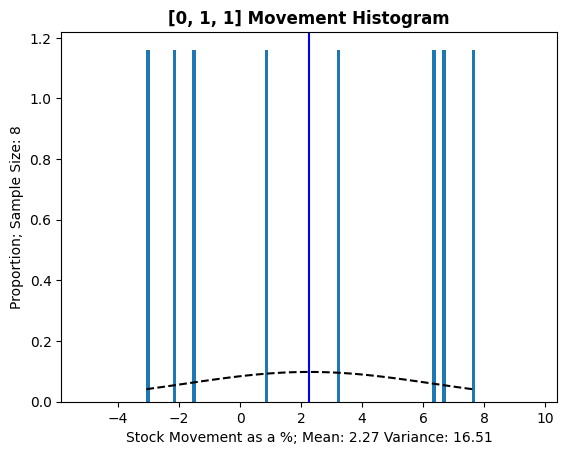

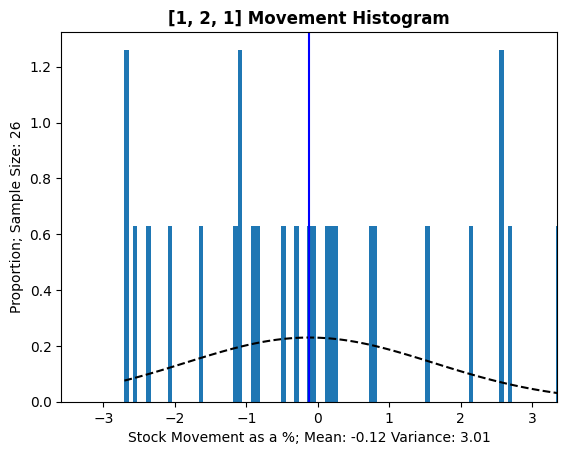

In [11]:
# Here I'm going to start working on plotting 
for count, stats in statistics.items():
  mean=stats[0]
  var=stats[1]
  n, bins, patches=plt.hist(movements[count],100,density=True)
  y = ((1 / (np.sqrt(2 * np.pi*var))) *
      np.exp(-0.5 * (1 / var) * (bins - mean)**2))
  plt.plot(bins, y, '--', color ='black')
  title=count+" Movement Histogram"
  plt.title(title,
          fontweight = "bold")
  plt.xlabel('Stock Movement as a %; Mean: '+str(round(mean,2))+' Variance: '+str(round(var,2)))
  plt.ylabel('Proportion; Sample Size: '+str(len(movements[count])))
  lim=min(10,2*np.sqrt(var))
  plt.xlim([mean-lim, mean+lim]) 
  plt.axvline(x = mean, color = 'b', label = 'axvline - full height')
  plt.show()